# Object Detection using Faster R-CNN (TensorFlow)

## About the Project

CAPTCHA is commonly used to test whether a user is human or not, by asking the user to identify objects in a given image. In this project, object detection on a CAPTCHA imaage is implemented using Faster R-CNN which is a model trained on Open Images V4 with ImageNet pre-trained Inception Resnet V2 as image feature extractor.  

## Setup

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

# For downloading the image
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring inference time
import time

## Load Object Detection Model

In [3]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


## Image Processing Helper Functions

In [4]:
#helper function to plot image
def display_image(image):
    fig = plt.figure(figsize=(40, 30))
    plt.grid(False)
    plt.imshow(image)

#helper function to download amd resize image from given URL
def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
    _, filename = tempfile.mkstemp(suffix=".jpg")
    response = urlopen(url)
    image_data = response.read()
    image_data = BytesIO(image_data)
    pil_image = Image.open(image_data)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert("RGB")
    pil_image_rgb.save(filename, format="JPEG", quality=90)
    print("Image downloaded to %s." % filename)
    if display:
        display_image(pil_image)
    return filename

#helper function to plot bounding box on image
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
    #To add a bounding box to an image.
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin

#helper function to overlay labelled boxes with scores and names on image
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.5):
    colors = list(ImageColor.colormap.values())[::-1]
    font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        #if class_names[i].decode("ascii") == "Car":
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                         int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(
              image_pil,
              ymin,
              xmin,
              ymax,
              xmax,
              color,
              font,
              display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

#helper function to load image from given file
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

## Object Detection

In [5]:
def run_detector(detector, path, item):
    img = load_img(path)

    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()

    result = {key:value.numpy() for key,value in result.items()}
    
    item_idx = []
    
    for i in range(result["detection_boxes"].shape[0]):
        if result["detection_class_entities"][i].decode("ascii") == item:
            item_idx.append(i)
   
    print(f"Found {len(item_idx)} instances of {item.lower()}.")
    print("Inference time: ", end_time-start_time)
  
    image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"][item_idx],
      result["detection_class_entities"][item_idx], result["detection_scores"][item_idx])

    display_image(image_with_boxes)

Found 13 instances of car.
Inference time:  58.52694296836853


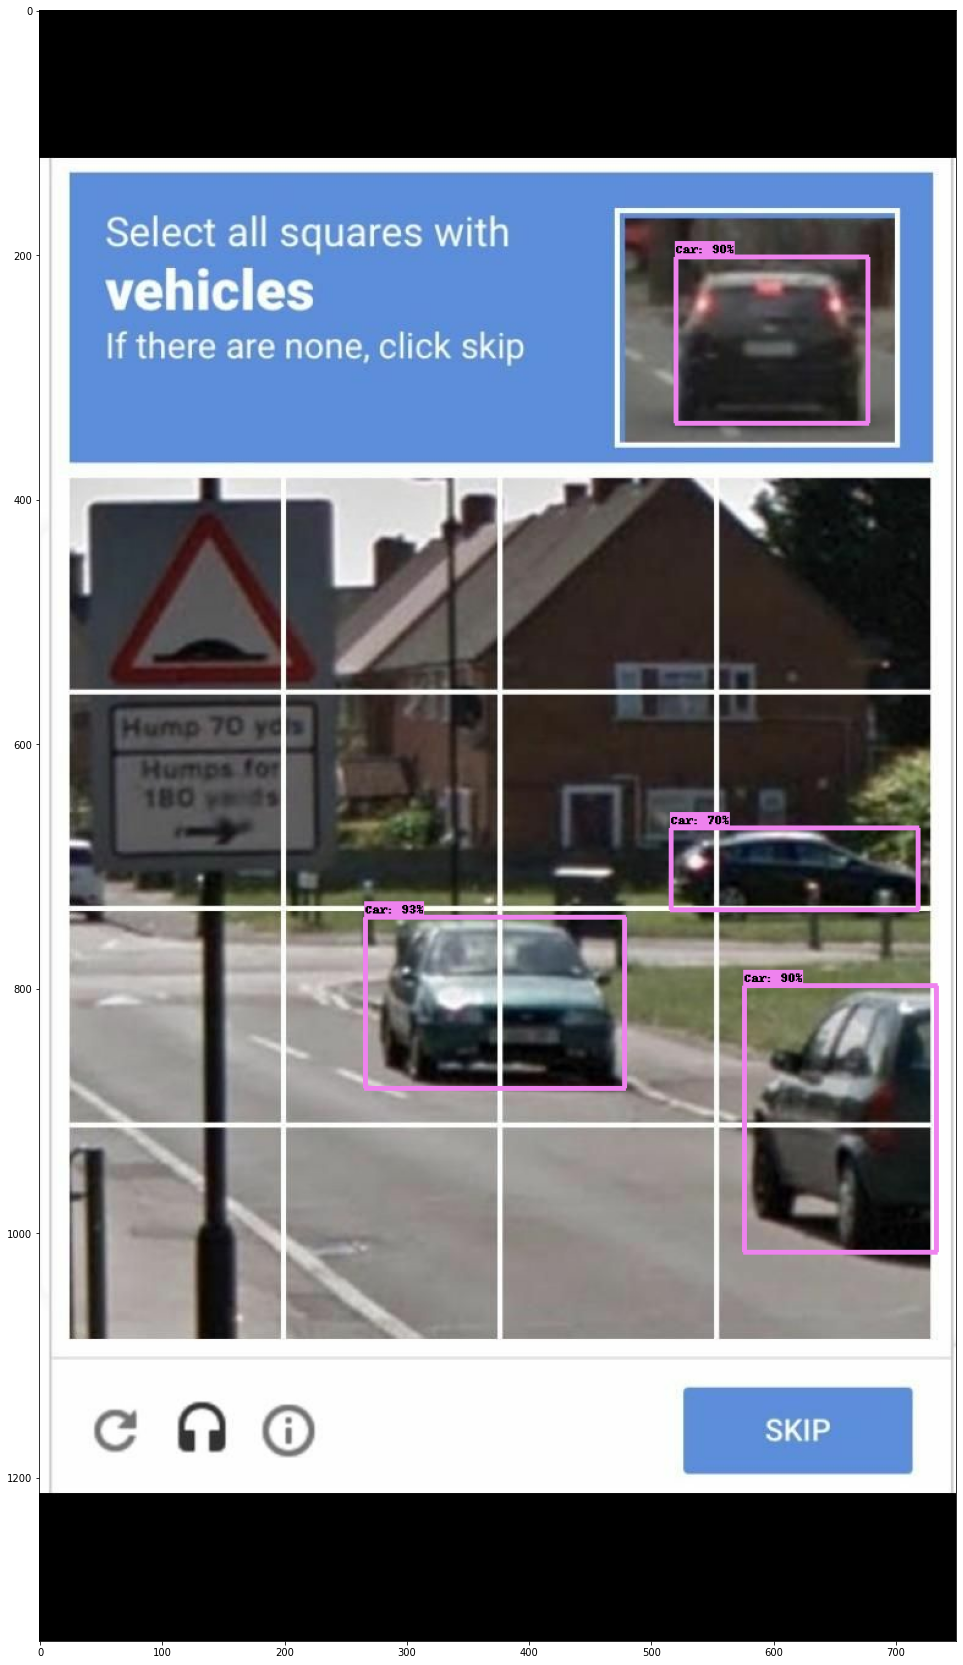

In [6]:
run_detector(detector, "captcha_car.jpg", "Car")